In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#from startup import *
import sys,os,glob
import subprocess

sysconfig={}
sysconfig['ccalin004']={'base':'/mnt/ceph/users/ckim/','source':'/mnt/home/ckim/Sources/pyathena-TIGRESS/'}
sysconfig['tigressdata.princeton.edu']={'base':'/tigress/changgoo/','source':'/tigress/changgoo/pyathena-TIGRESS/'}
sysconfig['tigressdata2.princeton.edu']={'base':'/tigress/changgoo/','source':'/tigress/changgoo/pyathena-TIGRESS/'}
sysconfig['cori']={'base':'/global/cscratch1/sd/changgoo/','source':'/global/u2/c/changgoo/pyathena/'}
sysconfig['princeton-macbook']={'base':'/Users/ckim/Research/TIGRESS/','source':'/Users/ckim/Sources/pyathena-TIGRESS/'}

sysname=os.uname()[1]

if sysname in sysconfig:
    print('### setting up for %s system' % sysname)
    sys.path.insert(0,sysconfig[sysname]['source'])
    base=sysconfig[sysname]['base']
    sourcedir=sysconfig[sysname]['source']
    print('### base directory path is %s' % base)
else:
    print('### no system is matched with %s' % sysname)

#import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.colors import LogNorm,Normalize,SymLogNorm
import cmocean

### setting up for tigressdata2.princeton.edu system
### base directory path is /tigress/changgoo/


In [3]:
import matplotlib.pyplot as plt
# Figure
plt.rcParams['figure.figsize']=(8,6)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.bbox']='tight'

# Font
plt.rcParams['font.size']=20
plt.rcParams['font.weight'] = 300

# Axes
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.width']=2
plt.rcParams['ytick.major.width']=2
plt.rcParams['xtick.major.size']=5
plt.rcParams['ytick.major.size']=5

# Line
plt.rcParams['lines.linewidth']=2

# Image
plt.rcParams['image.origin']='lower'

In [2]:
# %load obtain_mvz.py
import yt
from yt import derived_field
from yt.units.unit_object import Unit
from yt.units import kpc, pc, kboltz, mh
import numpy as np
import sys
import matplotlib.pyplot as plt
from math import *

import cooling
cf=cooling.coolftn()

#def _temp(field, data):
#    return  (mh*data['gas',"pressure"]/data['gas',"density"]/kboltz)

def _T1(field, data):
        return data["gas","pressure"]/data["gas","density"]*mh/kboltz

def _mu(field, data):
        T1=data["gas","T1"].d
        temp=cf.get_temp(T1)
        return temp/T1

def _temperature(field,data):
        return data["gas","T1"]*data["gas","mu"]
    
def _vout(field,data):
        return data["gas","velocity_z"]*data['z']/abs(data['z'])
    
yt.add_field(("gas", "T1"), function=_T1, units='K')
yt.add_field(("gas", "mu"), function=_mu, units='')
yt.add_field(("gas", "temperature"), function=_temperature, units='K')
yt.add_field(("gas", "vout"), function=_vout, units='km/s')

unit_base={"length_unit": (1.0,"pc"),
           "time_unit": (1.0,"s*pc/km"),
           "mass_unit": (2.38858753789e-24,"g/cm**3*pc**3"),
           "velocity_unit": (1.0,"km/s"),
           "magnetic_unit": (5.4786746797e-07,"gauss")}
tigress_unit_system=yt.UnitSystem('tigress','pc','Msun','Myr',)
tigress_unit_system['velocity']='km/s'
tigress_unit_system['magnetic_field']='uG'



/tigress/changgoo/miniconda3/lib/python3.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [4]:
from pyathena.set_plt import toggle_yticks,toggle_xticks
plt.rcParams['font.size']=16
def pdf_plot(pdf,xbin,ybin,label='Mass Fraction'):
    fig,axes=plt.subplots(2,2,sharex=False, sharey=False, 
                          gridspec_kw={'hspace':0,'wspace':0,'width_ratios':[2,1],'height_ratios':[2,1]})
    ax=axes[0,0]

    im=ax.pcolormesh(xbin,ybin,pdf,norm=LogNorm())
    im.set_clim(5.e-9,5.e-2)
    im.set_cmap('cubehelix_r')
    ax.set_xscale('log')
    ax.set_ylim(-250,550)
    ax.set_xlim(10,1.e8)
    ax.set_ylabel(r'$v_{\rm out}$ [km/s]')
    toggle_xticks([ax])
    for t0 in [184,5050,2.e4,5.e5]:
        ax.axvline(t0,ls=':')

    ax=axes[1,0]
    ax.step(xbin[1:],pdf.sum(axis=0))
    outflow = ybin[1:] > 50
    
    ax.step(xbin[1:],pdf[outflow,:].sum(axis=0),color='C6',label=r'$v_{\rm out}>50\,{\rm km/s}$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(10,1.e8)
    ax.set_ylim(1.e-8,1.e-1)
    #ax.set_ylabel('Mass Fraction')
    ax.set_xlabel('T [K]')
    for t0 in [184,5050,2.e4,5.e5]:
        ax.axvline(t0,ls=':')

    ax=axes[0,1]
    
    ax.step(pdf.sum(axis=1),ybin[1:])
    
    warm=xbin[1:]<2.e4
    inter=(xbin[1:]>2.e4) & (xbin[1:]<5.e5)
    hot=xbin[1:]>5.e5
    ax.step(pdf[:,warm].sum(axis=1),ybin[1:],color='green',label='warm')
    ax.step(pdf[:,inter].sum(axis=1),ybin[1:],color='orange',label='intermediate')
    ax.step(pdf[:,hot].sum(axis=1),ybin[1:],color='red',label='hot')

    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_ylim(-250,550)
    ax.set_xlim(1.e-8,1.e-1)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    ax.set_xticks([1.e-7,1.e-4,1.e-1])
    #ax.set_xlabel('Mass Fraction')
    toggle_yticks([ax])

    axes[1,1].axis('off')
    plt.tight_layout()

    ax=axes[0,0]
    x0,y0,xl,yl=ax.get_position().bounds
    cax=fig.add_axes([x0,y0+yl,xl,0.02])
    cbar=fig.colorbar(im,cax=cax,label=label,orientation='horizontal')
    cax.xaxis.tick_top()
    cax.xaxis.set_label_position('top')

    return fig

In [5]:
filename = '/tigress/changgoo/MHD_4pc_new/id0/MHD_4pc_new.0450.vtk'

In [6]:
ds = yt.load(filename, units_override=unit_base, unit_system=tigress_unit_system)

yt : [INFO     ] 2019-04-11 13:51:57,092 Temporarily setting domain_right_edge = -domain_left_edge. This will be corrected automatically if it is not the case.
yt : [WARNING  ] 2019-04-11 13:51:57,527 Overriding code units: Use this option only if you know that the dataset doesn't define the units correctly or at all.
yt : [INFO     ] 2019-04-11 13:51:57,528 Overriding length_unit: 1 pc.
yt : [INFO     ] 2019-04-11 13:51:57,529 Overriding time_unit: 1 s*pc/km.
yt : [INFO     ] 2019-04-11 13:51:57,530 Overriding mass_unit: 2.38859e-24 g/cm**3*pc**3.
yt : [INFO     ] 2019-04-11 13:51:57,531 Overriding velocity_unit: 1 km/s.
yt : [INFO     ] 2019-04-11 13:51:57,531 Overriding magnetic_unit: 5.47867e-07 gauss.
yt : [INFO     ] 2019-04-11 13:51:57,545 Parameters: current_time              = 450.0002
yt : [INFO     ] 2019-04-11 13:51:57,546 Parameters: domain_dimensions         = [ 256  256 1792]
yt : [INFO     ] 2019-04-11 13:51:57,546 Parameters: domain_left_edge          = [ -512.  -512. 

In [7]:
data=ds.all_data()
cut_mid = data.cut_region(['(obj["z"]<=500) & (obj["z"]>=-500)']) 
cut_z1  = data.cut_region(['(abs(obj["z"])>500) & (abs(obj["z"])<1500)']) 
cut_z2  = data.cut_region(['(abs(obj["z"])>=1500)']) 
#cut_hot  = data.cut_region(['(obj["temperature"]>=0.5e6)']) 


In [8]:
mtot,tmp=data.quantities.total_mass()
vtot=data.quantities.total_quantity(['cell_volume'])

In [9]:
pdfs=[]
for region in [cut_mid,cut_z1,cut_z2]:
    pdf = yt.create_profile(region,['temperature','vout'],fields=['cell_mass','cell_volume'],
                       extrema={'temperature':(10,1.e8),'vout':(-1000,1000)},
                       n_bins=(350,250),logs={'temperature':True,'vout':False},
                       weight_field=None,fractional=False, units={'temperature':'K','vout':"km/s"})
    pdfs.append(pdf)

In [10]:
mf=[]
vf=[]
for pdf in pdfs:
    mf.append(pdf.field_data[('gas','cell_mass')]/mtot)
    vf.append(pdf.field_data[('gas','cell_volume')]/vtot)

In [11]:
for mf_,vf_ in zip(mf,vf):
    print(mf_.sum(),vf_.sum())
print(np.sum(mf),np.sum(vf))

0.9114202592240963 dimensionless 0.13950863906315394 dimensionless
0.07386725881314699 dimensionless 0.27901782308306017 dimensionless
0.014641113715568678 dimensionless 0.5814732142857143 dimensionless
0.9999286317528119 0.9999996764319283


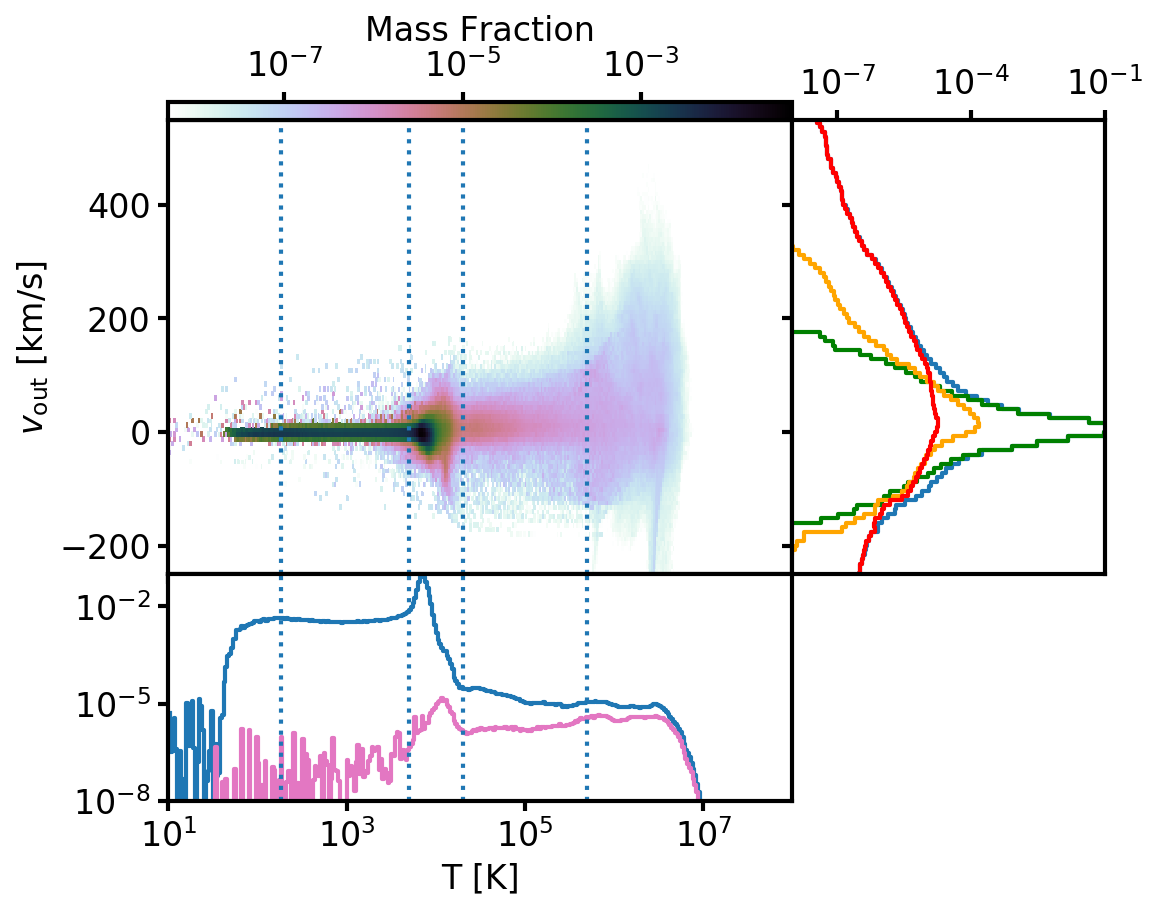

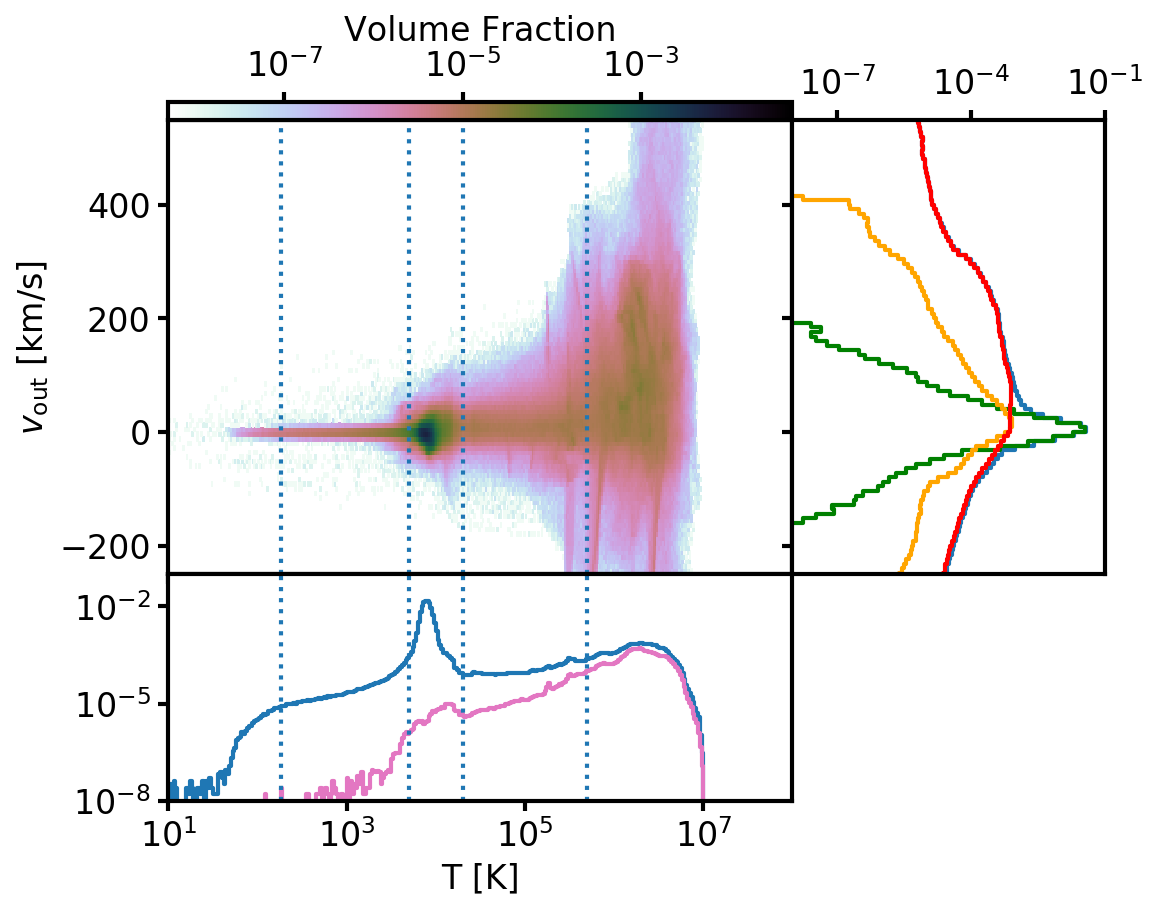

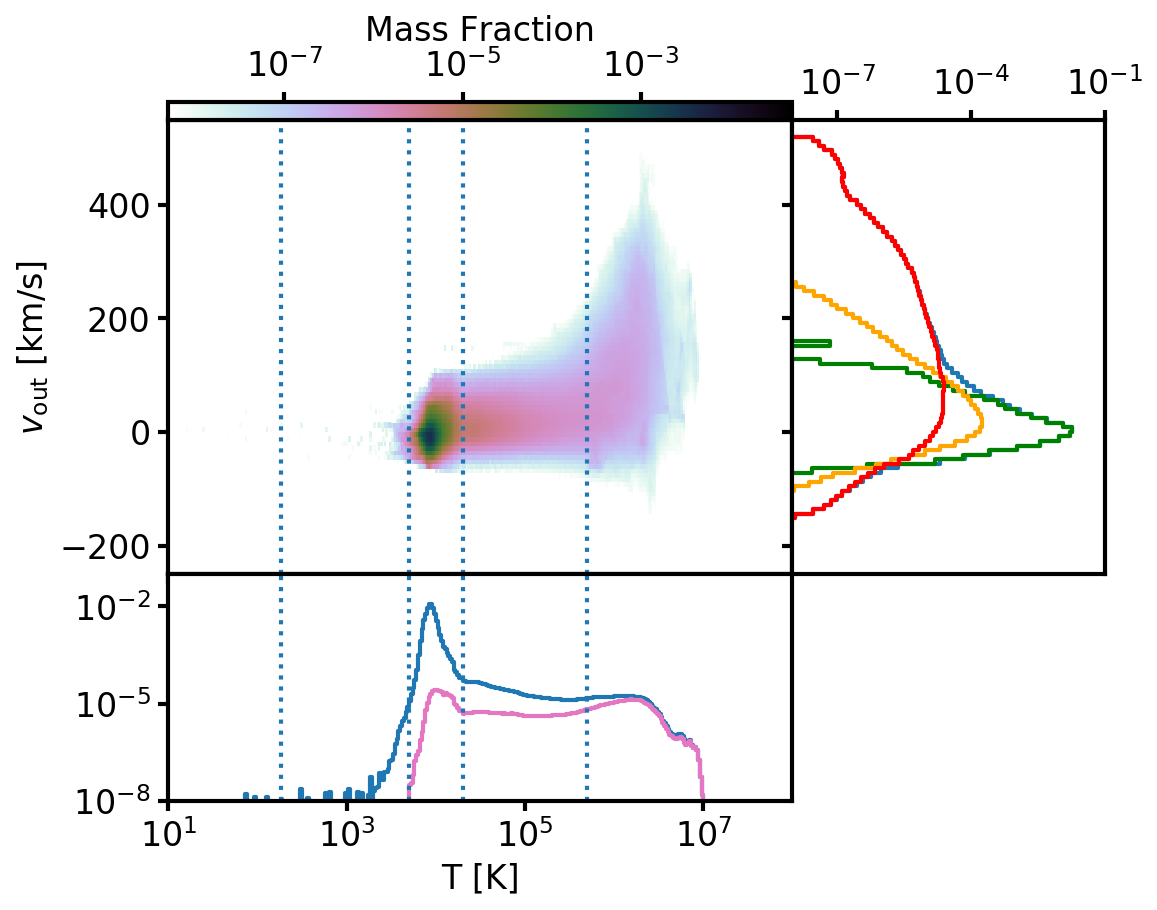

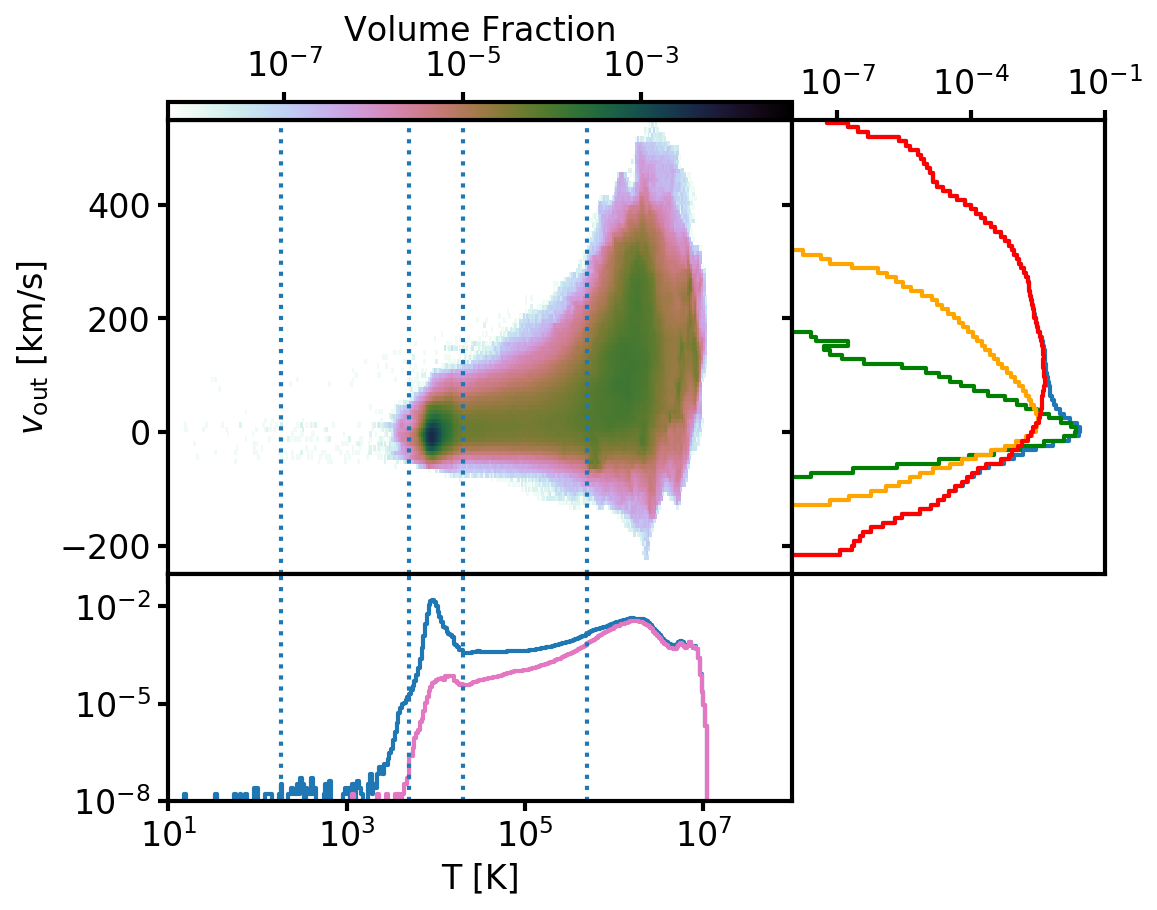

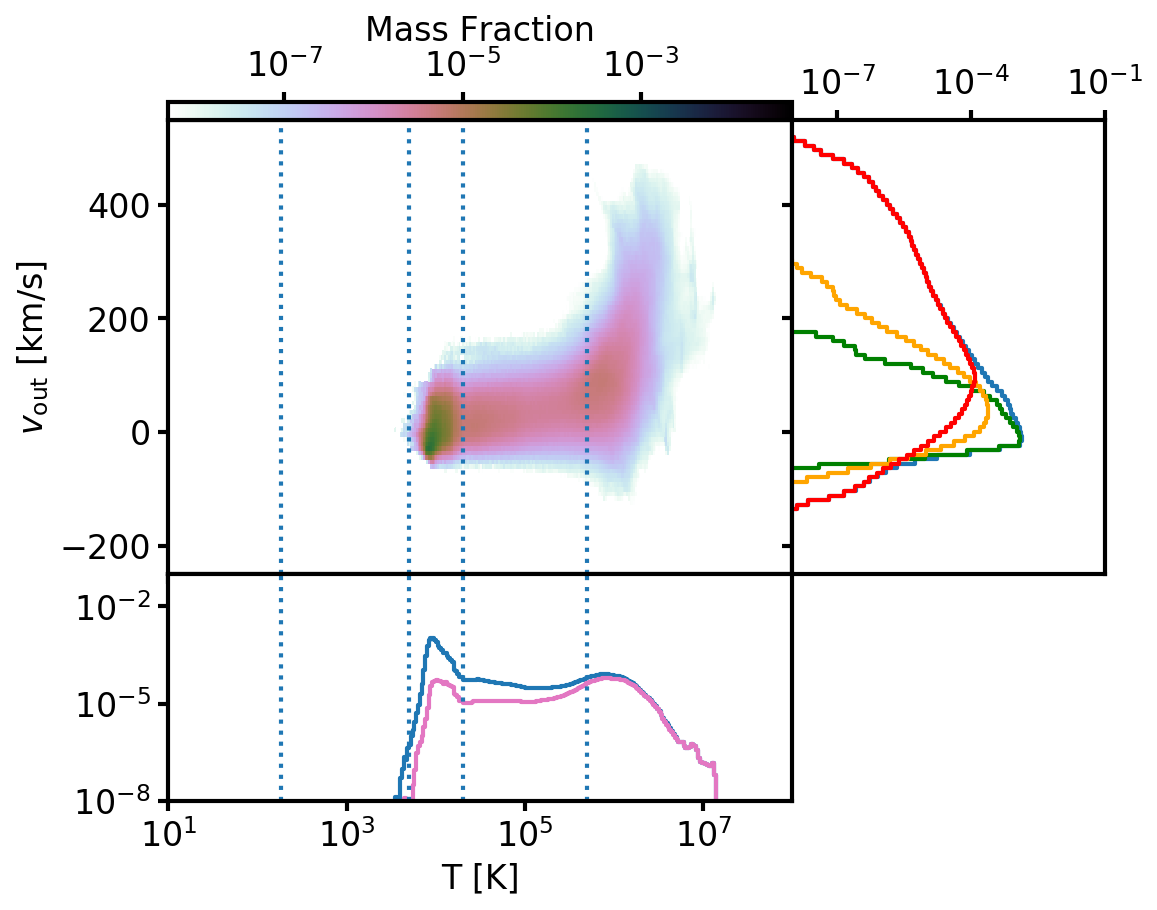

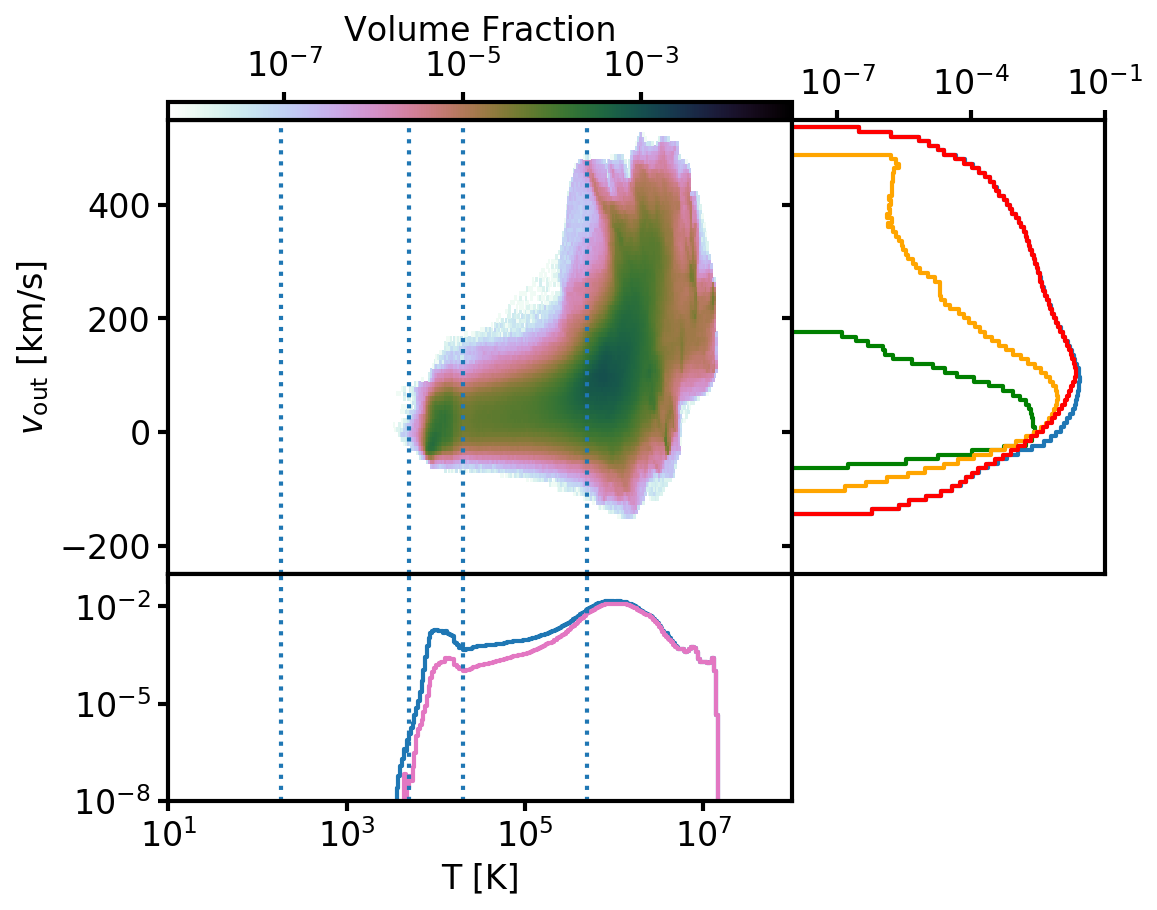

In [12]:
for mf_,vf_,pdf in zip(mf,vf,pdfs):
    xbin=pdf.x_bins.v
    ybin=pdf.y_bins.v
    fig1=pdf_plot(mf_.v.T,xbin,ybin,'Mass Fraction')
    fig2=pdf_plot(vf_.v.T,xbin,ybin,'Volume Fraction')

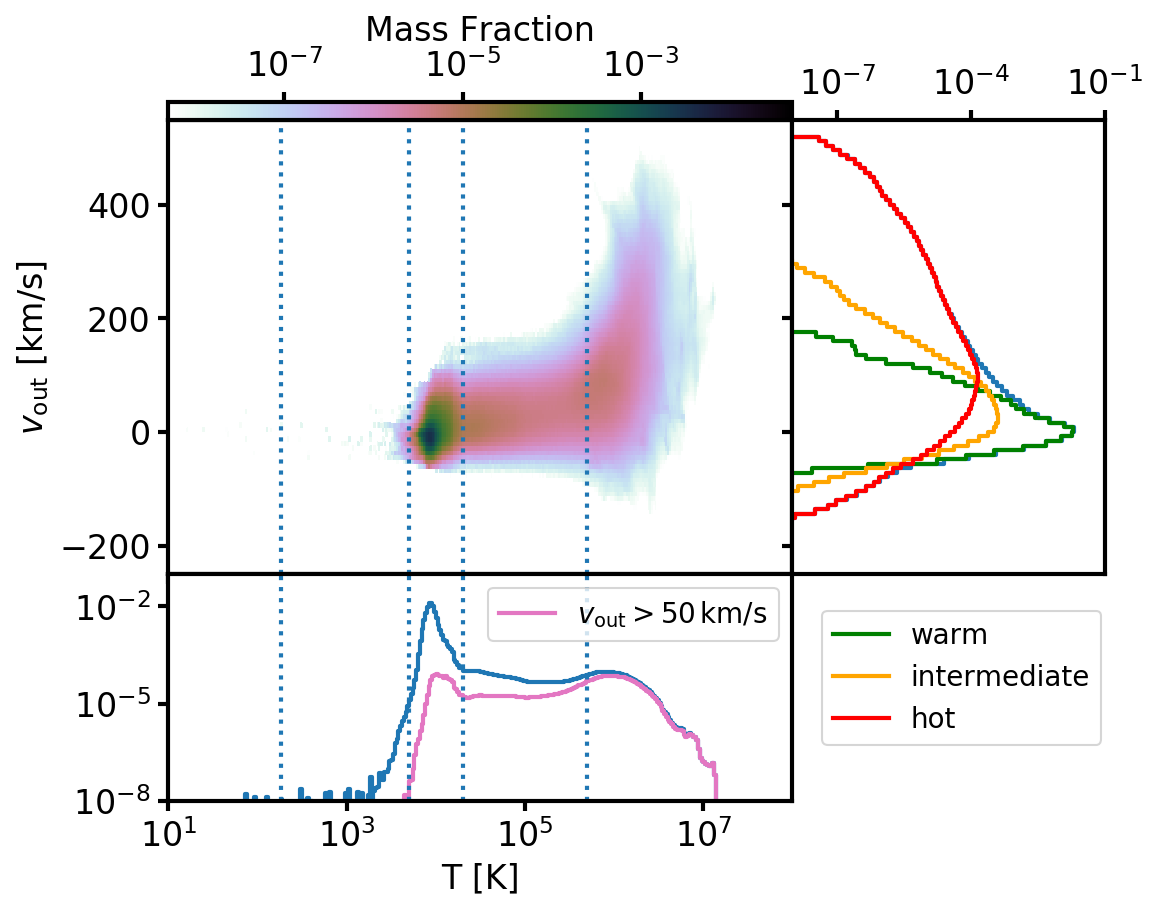

In [13]:
fig=pdf_plot((mf[1]+mf[2]).v.T,pdfs[1].x_bins.v,pdfs[1].y_bins.v)
axes=fig.axes
axes[1].legend(fontsize='small',loc='upper left',bbox_to_anchor=(0.05,-0.05))
axes[2].legend(fontsize='small')

In [14]:
outdir='/tigress/changgoo/public_html/TIGRESS_outflow/figures/'

In [15]:
fig.savefig('{}/pdfs.png'.format(outdir))
fig.savefig('{}/pdfs.pdf'.format(outdir))